Imports


In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
# from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Load data

In [2]:
data_path = "../udataset/health_data.csv"
df = pd.read_csv(data_path)
df = df.sort_values(by=["state", "year"])

Do PCA on data

In [3]:
features = df.drop(columns=["state", "year"])
no_components = 2
pca = PCA(n_components=no_components)
pca_features = pca.fit_transform(features)
df = pd.concat([df[["state", "year"]], pd.DataFrame(pca_features)], axis=1)
df

,state,year,0,1
264,Alabama,2011,-0.392001,-0.053076
265,Alabama,2012,-0.390391,0.056628
266,Alabama,2013,-0.272185,0.120431
267,Alabama,2014,-0.359922,0.074221
268,Alabama,2015,-0.254098,-0.008957
...,...,...,...,...
451,Wyoming,2018,0.174560,0.029309
452,Wyoming,2019,0.229688,-0.026006
453,Wyoming,2020,0.262339,0.106516
454,Wyoming,2021,0.377373,0.088344


# Simple clustering by year

In [4]:
# Drop the state column
state = df['state']
features = df.drop(['state'], axis=1)

start_year = df['year'].min()
end_year = df['year'].max()

Conduct silhouette method to determine groups

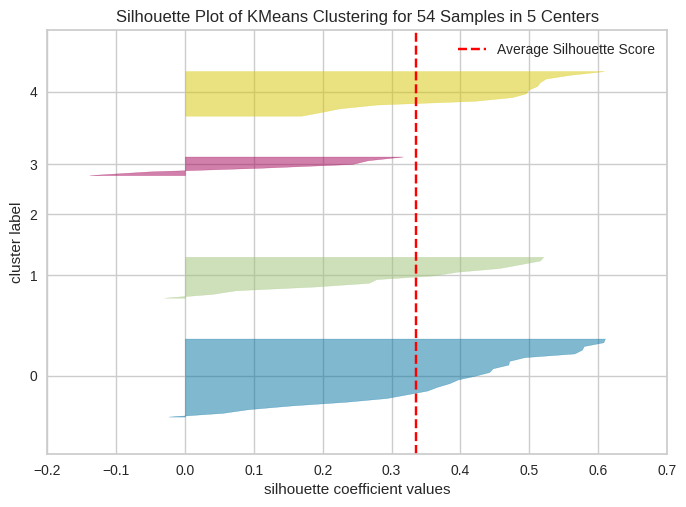

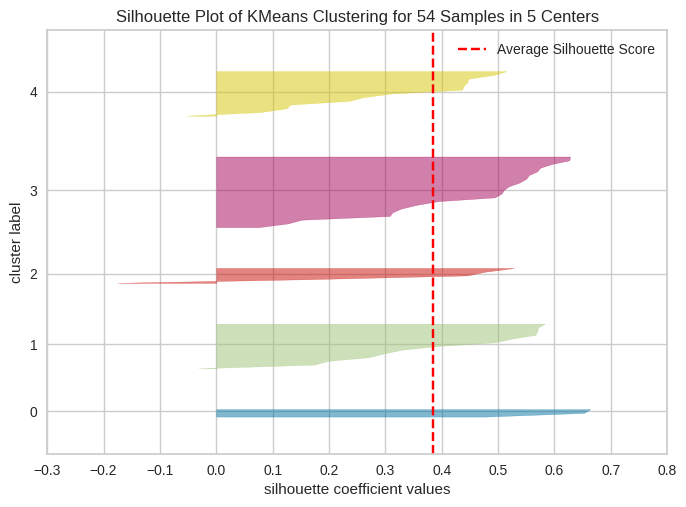

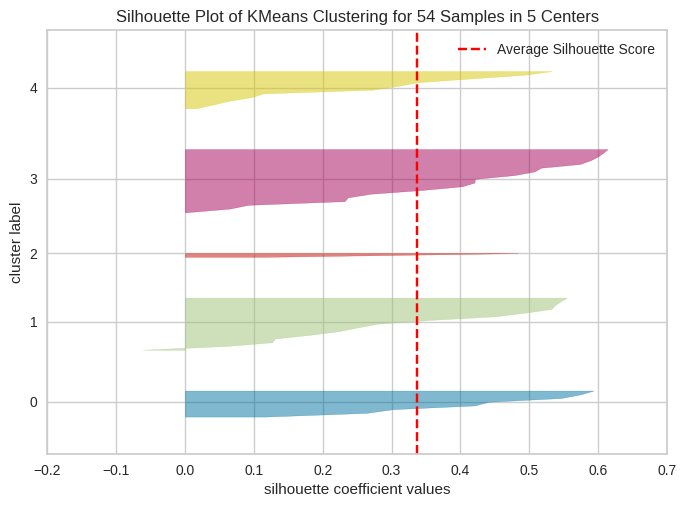

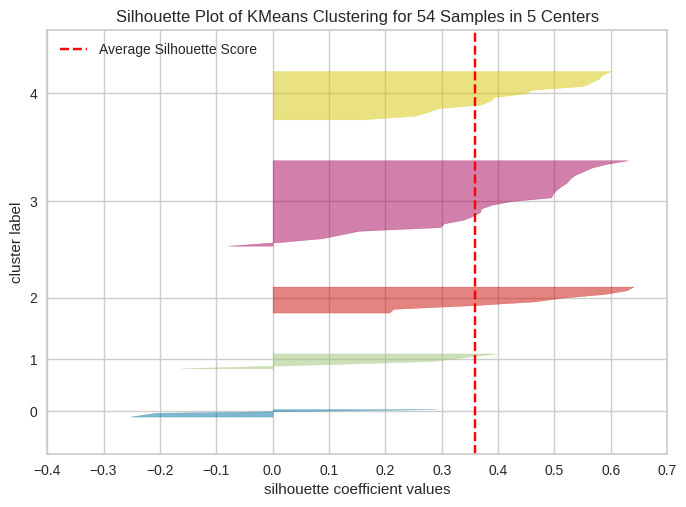

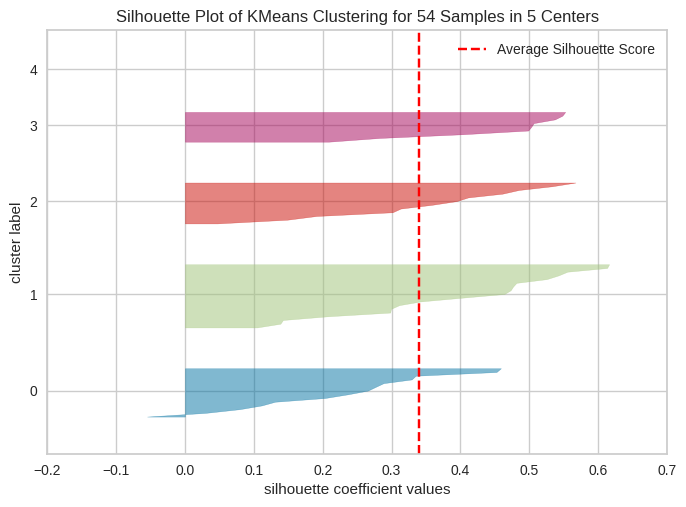

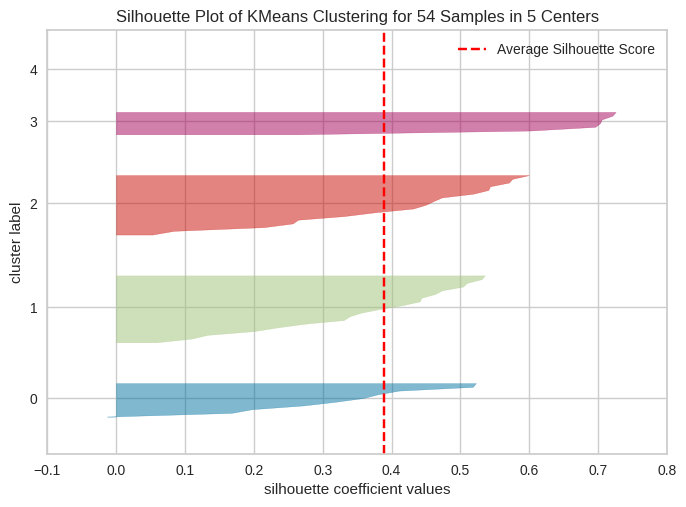

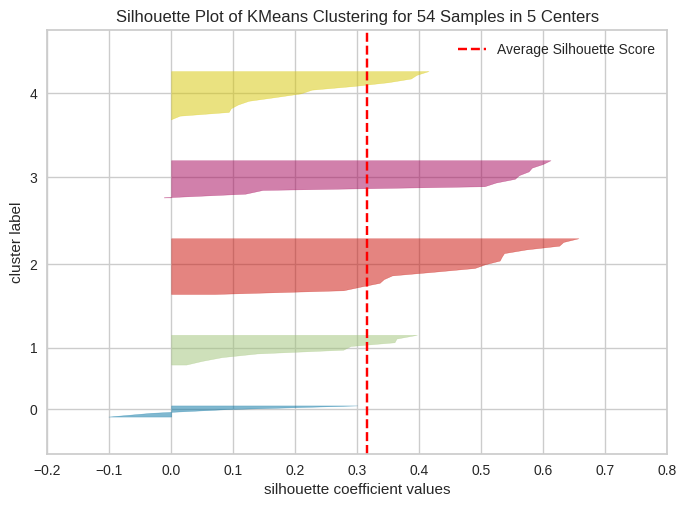

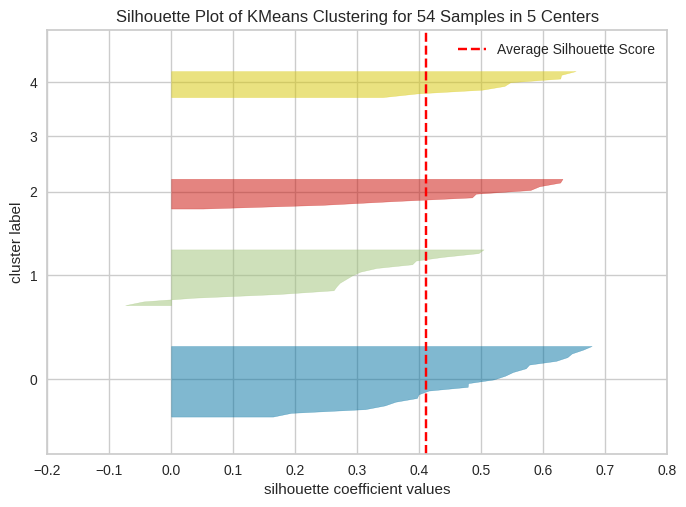

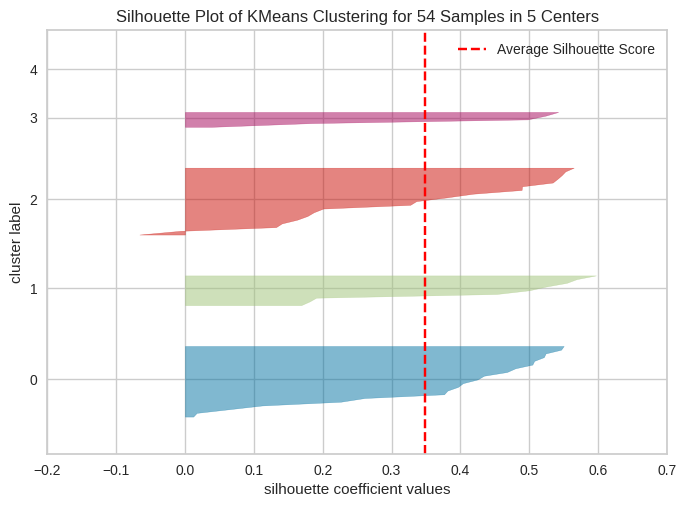

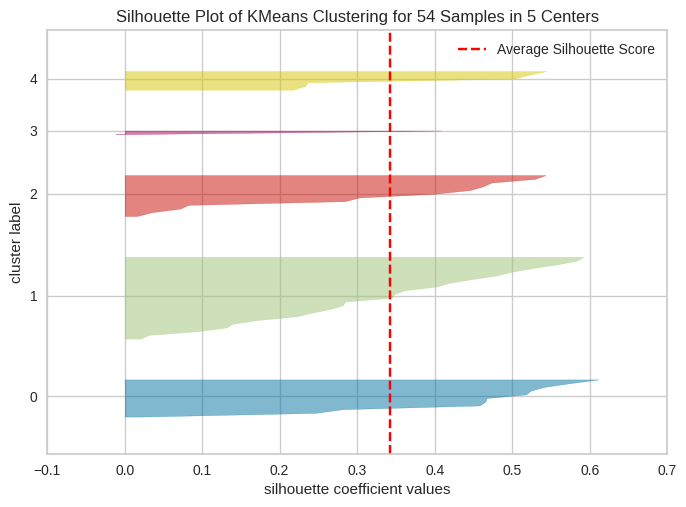

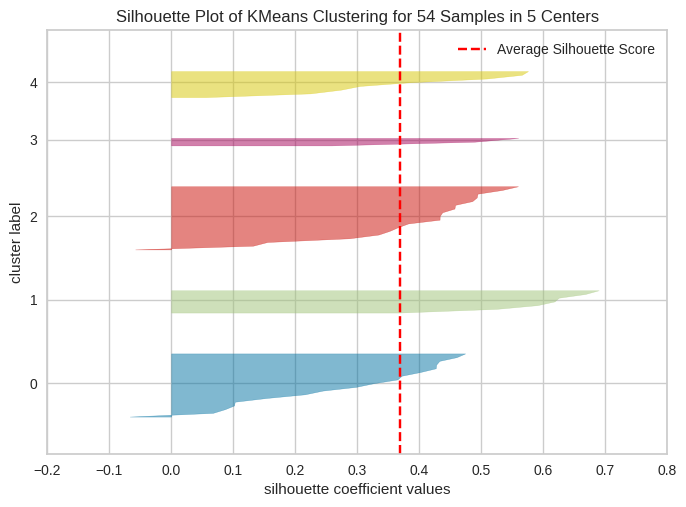

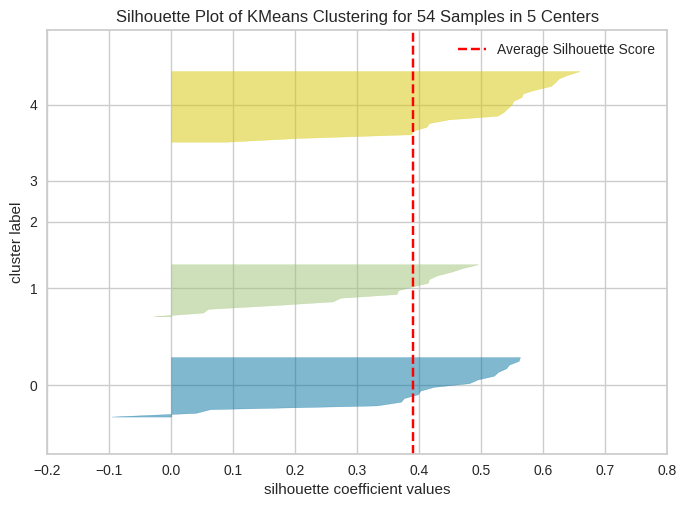

In [5]:
silhouettes = []
for year in range(start_year, end_year + 1):
    kmeans = KMeans(n_clusters=5, random_state=0)
    year_features = features[features['year'] == year].drop(['year'], axis=1)
    silhouette_visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    silhouette_visualizer.fit(year_features)
    silhouette_visualizer.show()


Predict clusters

In [6]:
df['cluster'] = pd.NA
num_clusters = 2
init = None
for year in range(start_year, end_year + 1):
    if init is None:
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    else:
        kmeans = KMeans(n_clusters=num_clusters, init=init, random_state=0)

    year_features = features[features['year'] == year].drop(['year'], axis=1)
    cluster = kmeans.fit_predict(year_features)
    df.loc[df['year'] == year, 'cluster'] = cluster
    init = kmeans.cluster_centers_

    print(f"Silhouette score for {year}: {silhouette_score(year_features, cluster)}")

df

Silhouette score for 2011: 0.37808384013472707
Silhouette score for 2012: 0.4012049719326824
Silhouette score for 2013: 0.39325797097292203
Silhouette score for 2014: 0.38129235160641783
Silhouette score for 2015: 0.38250490969216194
Silhouette score for 2016: 0.3837695273474956
Silhouette score for 2017: 0.4289263792128859
Silhouette score for 2018: 0.44681234905984224
Silhouette score for 2019: 0.43989675399956857
Silhouette score for 2020: 0.5067617279774784
Silhouette score for 2021: 0.4327437896190925
Silhouette score for 2022: 0.40244349791574113


,state,year,0,1,cluster
264,Alabama,2011,-0.392001,-0.053076,1
265,Alabama,2012,-0.390391,0.056628,1
266,Alabama,2013,-0.272185,0.120431,1
267,Alabama,2014,-0.359922,0.074221,1
268,Alabama,2015,-0.254098,-0.008957,1
...,...,...,...,...,...
451,Wyoming,2018,0.174560,0.029309,0
452,Wyoming,2019,0.229688,-0.026006,0
453,Wyoming,2020,0.262339,0.106516,0
454,Wyoming,2021,0.377373,0.088344,0


Reformat and name colums

In [7]:
# Move the cluster column to the start
cols = df.columns.tolist()
df = df[[cols[0]] + [cols[1]] +[ cols[-1]] + cols[2:-1]]

# Rename the principal components
pca_mapping = {i: f"PC{i+1}" for i in range(no_components)}
df = df.rename(columns=pca_mapping)

df

,state,year,cluster,PC1,PC2
264,Alabama,2011,1,-0.392001,-0.053076
265,Alabama,2012,1,-0.390391,0.056628
266,Alabama,2013,1,-0.272185,0.120431
267,Alabama,2014,1,-0.359922,0.074221
268,Alabama,2015,1,-0.254098,-0.008957
...,...,...,...,...,...
451,Wyoming,2018,0,0.174560,0.029309
452,Wyoming,2019,0,0.229688,-0.026006
453,Wyoming,2020,0,0.262339,0.106516
454,Wyoming,2021,0,0.377373,0.088344


In [8]:
print(df[(df['cluster'] == 1) &
    (df['year'] == 2021)]['state'])

274                 Alabama
382                Arkansas
574                Colorado
418                Delaware
34     District of Columbia
298                 Florida
478                 Georgia
370                Kentucky
58                 Maryland
514                Michigan
610                Missouri
82                  Montana
334           New Hampshire
394              New Jersey
106              New Mexico
118                New York
646                  Oregon
70             Rhode Island
154                   Texas
166                    Utah
586               Wisconsin
Name: state, dtype: object


Add visualization of groups

Text(0.5, 1.0, 'KMeans Clustering of States for Health Data (All years)')

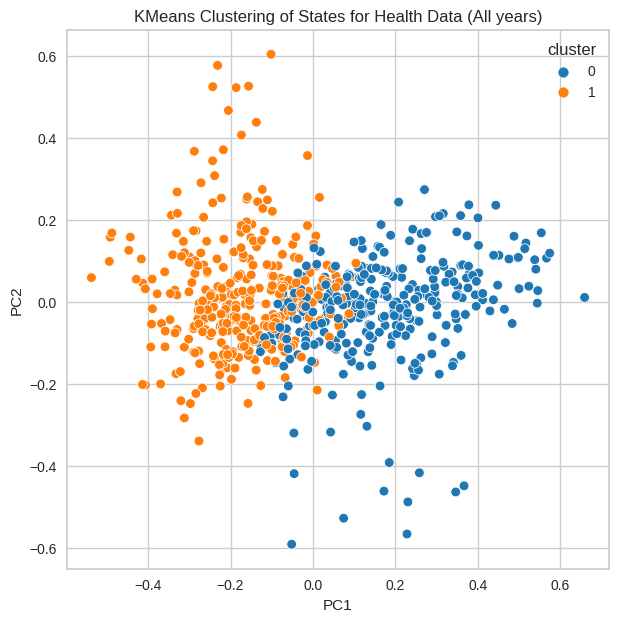

In [9]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df, x='PC1',
                y='PC2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering of States for Health Data (All years)")

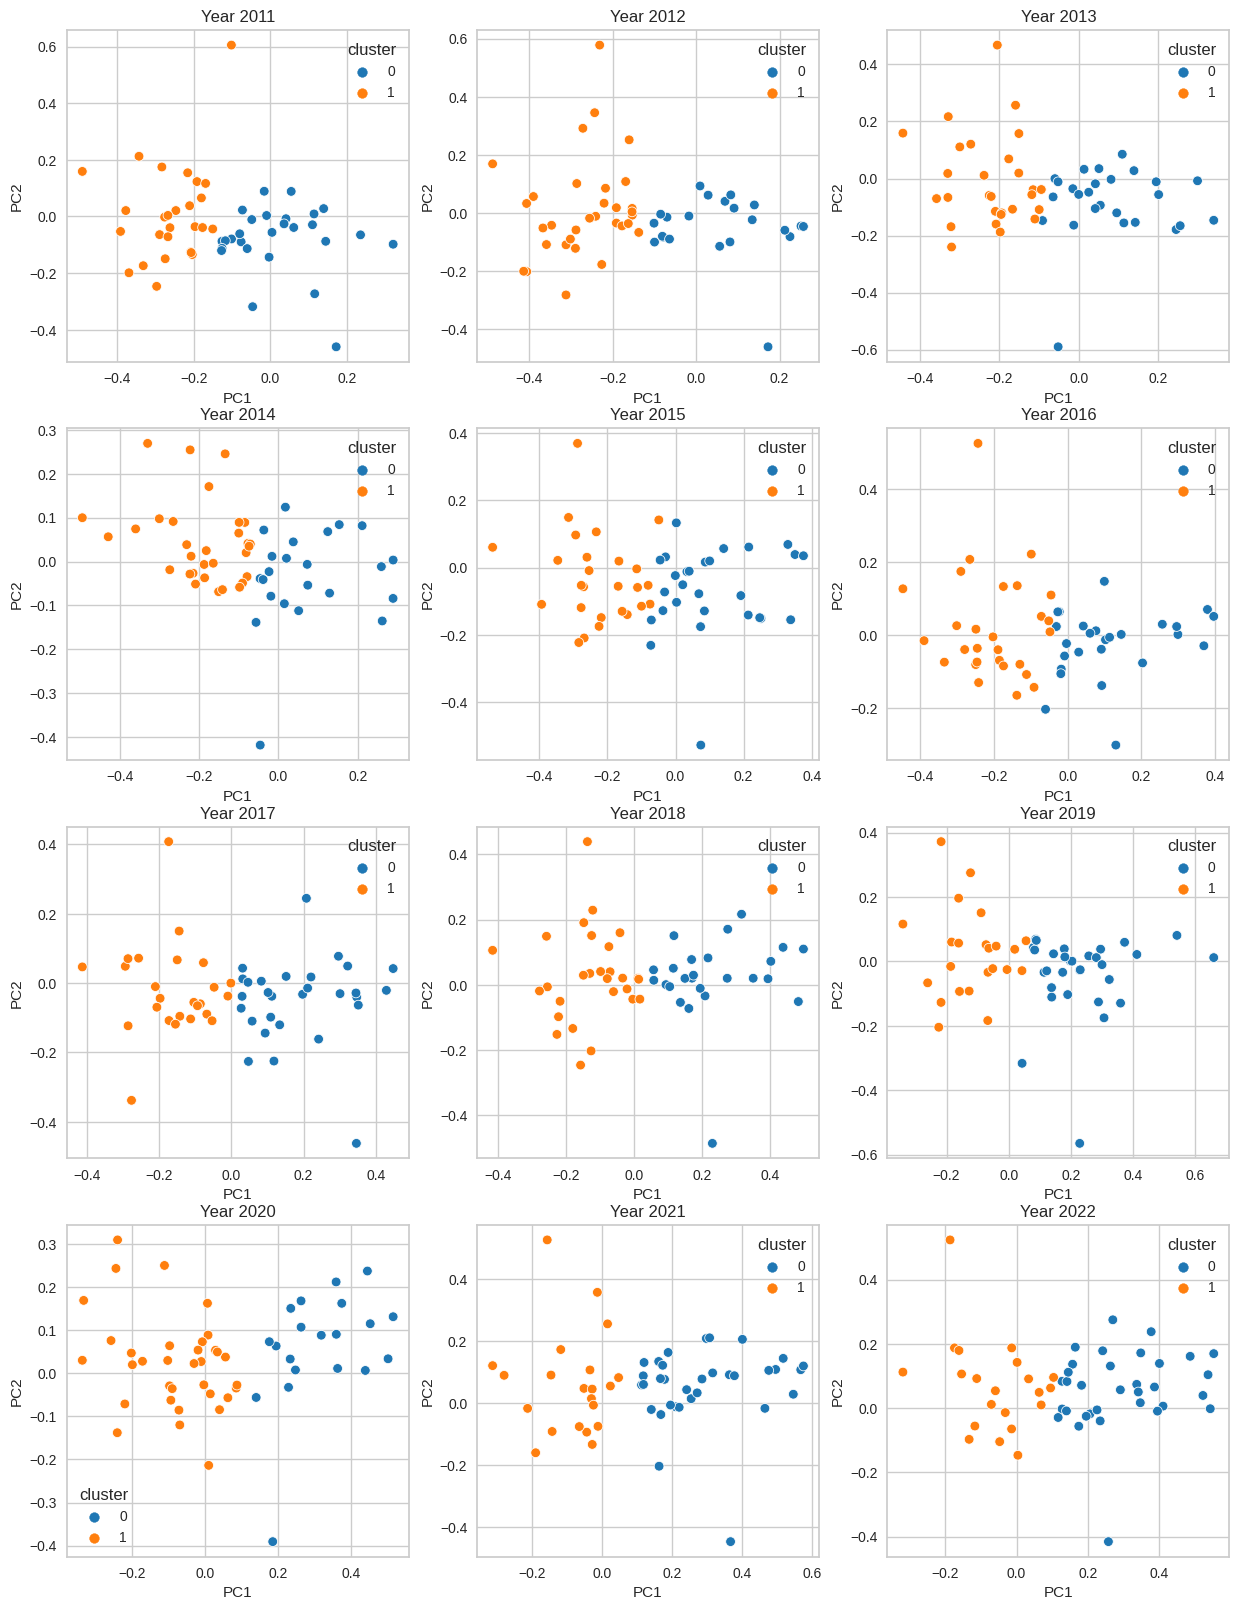

In [10]:
num_years = end_year - start_year + 1
col = 3
row = num_years // col + 1
plt.figure(figsize=(5 * col, 5 * row))

for i, year in enumerate(range(start_year, end_year + 1)):
    plt.subplot(row, col, i + 1)
    sns.scatterplot(data=df[df['year'] == year], x='PC1',
                    y='PC2', hue='cluster', palette='tab10')
    plt.title(f"Year {year}")

In [11]:
NEWNAME = 'health_data_clustered.csv'
df.to_csv('../udataset/' + NEWNAME, index=False)